# はじめてのNNabla

[関数近似で学ぶ chainer とディープラーニング](http://qiita.com/ashitani/items/1dc0a54da218ec224ad8)
の内容をNNablaで実装してみます。

In [1]:
import nnabla as nn

import nnabla.functions as F
import nnabla.parametric_functions as PF
import nnabla.solvers as S
from nnabla.monitor import tile_images

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

2017-08-17 03:00:25,539 [nnabla][INFO]: Initializing CPU extension...


データを作成します。

In [2]:
def get_batch(n):
    x = np.random.random(n)
    y = np.exp(x)
    return x,y

グラフを作成します。leaky ReLUがないのでeluで代用します。ミニバッチのサイズがネットワーク側に含まれるようです。

ということは、predictionの際に必要な入力が１データであっても100個ぶんの計算をしないといけない？→どうやら、スカラを渡すと100個分のベクタに展開されるらしい。実体もそうなのか、演算はしていないのかは不明。

In [3]:
batch_size = 100

x = nn.Variable((batch_size,1))

with nn.parameter_scope("affine1"):
    h1 = F.elu(PF.affine(x, 16))
with nn.parameter_scope("affine2"):
    h2 = F.elu(PF.affine(h1, 32))
with nn.parameter_scope("affine3"):
    y = F.elu(PF.affine(h2, 1))

ロス関数を定義します。

In [4]:
t = nn.Variable((batch_size,1))
loss = F.mean(F.squared_error(y, t))

forward()してみます。Valirableは.dでデータにアクセスできるようです。リードもライトも可能なようです。

In [5]:
dat=get_batch(batch_size)
x.d=dat[0].reshape((batch_size,1))
t.d=dat[1].reshape((batch_size,1))
loss.forward()
y.d[0]

array([-0.05339628], dtype=float32)

パラメータには下記のようにアクセスできるようです。なるほど。

In [6]:
params=nn.get_parameters()
print(params["affine1/affine/W"].d)

[[ 0.53453493  0.07619112 -0.52032226  0.50151753 -0.39791727 -0.36113101
  -0.06246556 -0.3155047   0.48113644  0.32035241 -0.36744836  0.18802148
  -0.54317921 -0.07468666 -0.12460474  0.53791457]]


solverの定義と学習です。

In [7]:
solver = S.Adam()
solver.set_parameters(nn.get_parameters())

In [8]:
losses=[]
for i in range(10000):
    dat=get_batch(batch_size)
    x.d=dat[0].reshape((batch_size,1))
    t.d=dat[1].reshape((batch_size,1))
    loss.forward()
    solver.zero_grad()
    loss.backward()
    solver.update()
    losses.append(loss.d.copy())
    if i % 1000 == 0:  # Print for each 10 iterations
        print(i, loss.d)

0 3.568746328353882
1000 0.005967390723526478
2000 0.005318371579051018
3000 0.003543429309502244
4000 0.00024910076172091067
5000 0.00010832439875230193
6000 7.780154555803165e-05
7000 5.546959437197074e-05
8000 4.115968113183044e-05
9000 3.122492853435688e-05


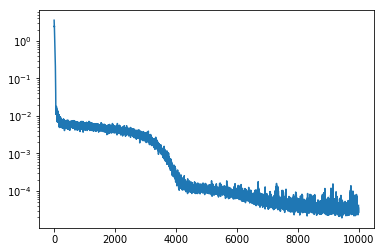

In [9]:
plt.plot(losses)
plt.yscale('log')

predictionをしてみましょう。任意のサブグラフに対してforward()ができるのですね。これは直感的です。

In [10]:
x.d= 0.2
y.forward()

In [11]:
print(y.d[0][0])
print(np.exp(0.2))

1.22917
1.22140275816


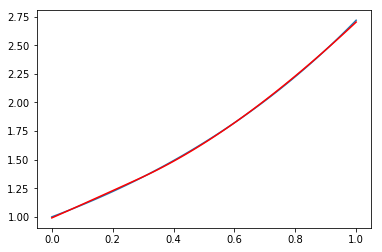

In [12]:
xi=np.linspace(0,1,100)
plt.plot(xi,np.exp(xi))
x.d = xi.reshape((100,1))
y.forward()
_=plt.plot(xi, y.d,"r")